In [116]:
using BenchmarkTools
using ProfileVega
using Distributions
using DataStructures
using LinearAlgebra
using Parameters
using Plots
using Random
using Statistics

import Base.Threads.@spawn

function pretty_print(variable, prefix="")
    print(prefix)
    show(IOContext(stdout, :limit => false), "text/plain", variable)
    println()
end

Threads.nthreads()

10

In [3]:
@with_kw mutable struct Unit 
    act::Float64        = 0.2
    avg_ss::Float64     = act
    avg_s::Float64      = act
    avg_m::Float64      = act
    
    net::Float64        = 0.0
    v_m::Float64        = 0.3
    vm_eq::Float64      = 0.3
    adapt::Float64      = 0.0
    spike::Bool         = false

    net_dt::Float64     = 1/1.4
    integ_dt::Float64   = 1.0;   # time step constant for integration of cycle dynamics
    vm_dt::Float64      = 1/3.3;  # time step constant for membrane potential
    l_dn_dt::Float64    = 1/2.5; # time step constant for avg_l decrease
    adapt_dt::Float64   = 1/144; # time step constant for adaptation
    ss_dt::Float64      = 0.5;    # time step for super-short average
    s_dt::Float64       = 0.5;     # time step for short average
    m_dt::Float64       = 0.1;     # time step for medium-term average
    avg_l_dt::Float64   = 0.1; # time step for long-term average
    avg_l_max::Float64  = 1.5; # max value of avg_l
    avg_l_min::Float64  = 0.1; # min value of avg_l
    avg_l::Float64      = avg_l_min
    e_rev_e::Float64    = 1.0;    # excitatory reversal potential
    e_rev_i::Float64    = 0.25;  # inhibitory reversal potential
    e_rev_l::Float64    = 0.3;  # leak reversal potential
    gc_l::Float64       = 0.1;     # leak conductance
    thr::Float64        = 0.5;      # normalized "rate threshold"
    spk_thr::Float64    = 1.2;  # normalized spike threshold
    vm_r::Float64       = 0.3;     # reset membrane potential after spike
    vm_gain::Float64    = 0.04; # gain that voltage produces on adaptation
    spike_gain::Float64 = 0.00805; # effect of spikes on adaptation
    l_up_inc::Float64   = 0.2; # increase in avg_l if avg_m has been 'large'     
end
    
function rel_avg_l(u::Unit)::Float64
    return (u.avg_l - u.avg_l_min)/(u.avg_l_max - u.avg_l_min)
end

function l_avg_rel(u::Unit)::Float64
    return (u.avg_l - u.avg_l_min)/(u.avg_l_max - u.avg_l_min)
end
# myunit = Unit()
# println(myunit)
function cycle(u::Unit, net_raw::Float64, gc_i::Float64)
    # Does one Leabra cycle. Called by the layer cycle method.
    # net_raw = instantaneous, scaled, received input
    # gc_i = fffb inhibition
    
    ## updating net input
    u.net = u.net + u.integ_dt * u.net_dt * (net_raw - u.net);
    
    ## Finding membrane potential
    I_net = u.net*(u.e_rev_e - u.v_m) + u.gc_l*(u.e_rev_l - u.v_m) + gc_i*(u.e_rev_i - u.v_m);
    # almost half-step method for updating v_m (adapt doesn't half step)
    v_m_h = u.v_m + 0.5*u.integ_dt*u.vm_dt*(I_net - u.adapt);
    I_net_h = u.net*(u.e_rev_e - v_m_h) + u.gc_l*(u.e_rev_l - v_m_h) + gc_i*(u.e_rev_i - v_m_h);
    u.v_m = u.v_m + u.integ_dt*u.vm_dt*(I_net_h - u.adapt);
    u.vm_eq = u.vm_eq + u.integ_dt*u.vm_dt*(I_net_h - u.adapt);
    
    ## Finding activation
    # finding threshold excitatory conductance
    g_e_thr = (gc_i*(u.e_rev_i-u.thr) + u.gc_l*(u.e_rev_l-u.thr) - u.adapt) / (u.thr - u.e_rev_e);
    # finding whether there's an action potential
    if u.v_m > u.spk_thr
        u.spike = true;
        u.v_m = u.vm_r;
    else
        u.spike = false;
    end
    # finding instantaneous rate due to input

    if u.vm_eq <= u.thr
        new_act = nxx1(u.vm_eq - u.thr)[1];
    else
        new_act = nxx1(u.net - g_e_thr)[1];
    end

    # println("begin unit stuff")
    # println((u.act))
    # println((u.integ_dt))
    # println((u.vm_dt))
    # println((new_act))
    # println("end unit stuff")
    # ()
    # ()
    # ()
    # (1,)

    # 0.0
    # 1.0
    # 0.30303030303030304
    # [1.4138202523385987e-41] 

    # update activity
    u.act = u.act + u.integ_dt * u.vm_dt * (new_act - u.act);

    ## Updating adaptation
    u.adapt = u.adapt + u.integ_dt*(u.adapt_dt*(u.vm_gain*(u.v_m - u.e_rev_l)  - u.adapt) + u.spike*u.spike_gain);
          
    ## updating averages
    u.avg_ss = u.avg_ss + u.integ_dt * u.ss_dt * (u.act - u.avg_ss);
    u.avg_s = u.avg_s + u.integ_dt * u.s_dt * (u.avg_ss - u.avg_s);
    u.avg_m = u.avg_m + u.integ_dt * u.m_dt * (u.avg_s - u.avg_m); 
end

       


function updt_avg_l(u::Unit)
    # This fuction updates the long-term average 'avg_l' 
    # u = this unit
    # Based on the description in:
    # https://grey.colorado.edu/ccnlab/index.php/Leabra_Hog_Prob_Fix#Adaptive_Contrast_Impl
    
    if u.avg_m > 0.2
        u.avg_l = u.avg_l + u.avg_l_dt*(u.avg_l_max - u.avg_m);
    else
        u.avg_l = u.avg_l + u.avg_l_dt*(u.avg_l_min - u.avg_m);
    end
end

function reset(u::Unit)
    # This function sets the activity to a random value, and sets
    # all activity time averages equal to that value.
    # Used to begin trials from a random stationary point.
    #u.act = 0.05 + 0.9*rand;
    u.act = 0.0;  # Randy begins trials with act=0
    u.avg_ss = u.act;
    u.avg_s = u.act;
    u.avg_m = u.act;
    u.avg_l = u.act;
    u.net = 0.0;
    u.v_m = 0.3;
    u.vm_eq = 0.3;
    u.adapt = 0.0;            
    u.spike = 0.0;            
end

# function nxx1(points) # replaced by go nxx1 version instead?
#     # f = nxx1(points) calculates the noisy x/(x+1) function for
#     # all values in the vector 'points'. The returned values come
#     # from the convolution of x/(x+1) with a Gaussian function.
#     # To avoid calculating the convolution every time, the first
#     # time the function is called a vector 'nxoxp1' is created,
#     # corresponding to the values of nxx1 at all the points in the
#     # vector 'nxx1_dom'. Once these vectors are in the workspace,
#     # subsequent calls to nxx1 use interpolation with these
#     # vectors in order to calculate their return values.
    
#     persistent nxoxp1 nxx1_dom
    
#     if isempty(nxoxp1) || isempty(nxx1_dom)
#     # we don't have precalculated vectors for interpolation
#         n_points = 2000; # size of the precalculated vectors
#         gain = 100; # gain of the xx1 function
#         mid = 2; # mid length of the domain
#         domain = linspace(-mid,mid,n_points); # will be 'nxx1_dom'
#         dom_g = linspace(-2*mid,2*mid,2*n_points); # domain of Gaussian
#         values = zeros(1,n_points); # will be 'nxoxp1'
#         sd = .005; # standard deviation of the Gaussian
#         gaussian = exp(-(dom_g.^2)/(2*sd^2))/(sd*sqrt(2*pi));
#         xx1 = max(gain*domain,zeros(1,n_points))./(max(gain*domain,zeros(1,n_points))+1);
        
#         for p = 1:n_points
#             low = n_points - p + 1;
#             high = 2*n_points - p;
#             values(p) = sum(xx1.*gaussian(low:high));
#             values(p) = values(p)/sum(gaussian(low:high));
#         end
#         nxx1_dom = domain;
#         nxoxp1 = values;  
#         #disp('First call to nxx1!');
#     end
#     f = interp1(nxx1_dom,nxoxp1,points,'nearest','extrap');
# end
# end

reset (generic function with 1 method)

In [4]:
function XX1(x::Float64)
    return x / (x + 1)
end

function XX1GainCor(x::Float64, GainCorRange, NVar, Gain, GainCor)
    gainCorFact = (GainCorRange - (x / NVar)) / GainCorRange
    if gainCorFact < 0
        return XX1(Gain * x)
    end
    newGain = Gain * (1 - GainCor*gainCorFact)
    return XX1(newGain * x)
end     

@with_kw mutable struct NXX1Params
    Thr::Float64            = 0.5
    Gain::Int64             = 100
    NVar::Float64           = 0.005
    VmActThr::Float64       = 0.01
    SigMult::Float64        = 0.33
    SigMultPow::Float64     = 0.8
    SigGain::Float64        = 3.0
    InterpRange::Float64    = 0.01
    GainCorRange::Float64   = 10.0
    GainCor::Float64        = 0.1

	SigGainNVar::Float64    = SigGain / NVar
	SigMultEff::Float64     = SigMult * ((Gain* NVar) ^ SigMultPow)
	SigValAt0::Float64      = 0.5 * SigMultEff
	InterpVal::Float64      = XX1GainCor(InterpRange, GainCorRange, NVar, Gain, GainCor) - SigValAt0
end


function XX1GainCor(x::Float64, xp::NXX1Params)
    gainCorFact = (xp.GainCorRange - (x / xp.NVar)) / xp.GainCorRange
    if gainCorFact < 0
        return XX1(xp.Gain * x)
    end
    newGain = xp.Gain * (1 - xp.GainCor*gainCorFact)
    return XX1(newGain * x)
end  

function NoisyXX1(x::Float64, xp::NXX1Params)
	if x < 0
		return xp.SigMultEff / (1 + exp(-(x * xp.SigGainNVar)))
	elseif x < xp.InterpRange
		interp = 1 - ((xp.InterpRange - x) / xp.InterpRange)
		return xp.SigValAt0 + interp*xp.InterpVal
	else
		return XX1GainCor(x, xp)
    end
end

function XX1GainCorGain(x::Float64, gain::Float64, xp::NXX1Params)
	gainCorFact = (xp.GainCorRange - (x / xp.NVar)) / xp.GainCorRange
	if gainCorFact < 0
		return XX1(gain * x)
    end
	newGain = gain * (1 - xp.GainCor*gainCorFact)
	return XX1(newGain * x)
end

function NoisyXX1Gain(x::Float64, gain::Float64, xp::NXX1Params)
	if x < xp.InterpRange
		sigMultEffArg = xp.SigMult * (gain*xp.NVar ^ xp.SigMultPow)
		sigValAt0Arg = 0.5 * sigMultEffArg

		if x < 0 # sigmoidal for < 0
			return sigMultEffArg / (1 + exp(-(x * xp.SigGainNVar)))
		else # else x < interp_range
			interp = 1 - ((xp.InterpRange - x) / xp.InterpRange)
			return sigValAt0Arg + interp*xp.InterpVal
        end
	else
		return xp.XX1GainCorGain(x, gain, xp)
    end
end

function test_nxx1()
    difTol = 1.0e-7
    xx1 = NXX1Params()

    tstx = [-0.05, -0.04, -0.03, -0.02, -0.01, 0, .01, .02, .03, .04, .05, .1, .2, .3, .4, .5]
    cory = [1.7735989e-14, 7.155215e-12, 2.8866178e-09, 1.1645374e-06, 0.00046864923, 0.094767615, 0.47916666, 0.65277773, 0.742268, 0.7967479, 0.8333333, 0.90909094, 0.95238096, 0.96774197, 0.9756098, 0.98039216]
    ny = Array{Float64}(undef, length(tstx))

    for i in 1:length(tstx)
        ny[i] = NoisyXX1(tstx[i], xx1)
        dif = abs(ny[i] - cory[i])
        if dif > difTol # allow for small numerical diffs
            println("XX1 err: dix: $i, x: $(tstx[i]), y: $(ny[i]), cor y: $(cory[i]), dif: $dif")
        end
    end
end

function nxx1(points)
    xp = NXX1Params()
    results = Array{Float64}(undef, length(points))
    for (index,value) in enumerate(points)
        results[index] = NoisyXX1(value, xp)
    end
    return results
end

test_nxx1()

In [65]:
# net.layers[i].wt = Array{Unit, 2}(undef, (net.layers[i].N, lay_inp_size[i]))

@with_kw mutable struct Layer 
    units::Array{Unit}
    pct_act_scale::Float64
    acts_p_avg::Float64
    netin_avg::Float64
    wt::Array{Float64, 2}
    ce_wt::Array{Float64, 2}
    N::Int64
    fbi::Float64

    ff::Float64     = 1.0
    ff0::Float64    = 0.1
    fb::Float64     = 0.5
    fb_dt::Float64  = 1/1.4 # time step for fb inhibition (fb_tau=1.4)
    gi::Float64     = 2.0
    avg_act_dt::Float64 = 0.01
end

function layer(dims::Tuple{Int64, Int64} = (1,1))
    N = dims[1]*dims[2]
    # lay.units = unit.empty;  # so I can make the assignment below
    # lay.units(lay.N,1) = unit; # creating all units
    # # notice how the unit array is 1-D. The 2-D structure of the
    # # layer doesn't have meaning in this part of the code 
    
    # units = Array{Unit, 1}(undef, N)
    units = [Unit() for i in 1:N]
    
    ff     = 1.0
    ff0    = 0.1
    fb     = 0.5
    fb_dt  = 1/1.4 # time step for fb inhibition (fb_tau=1.4)
    gi     = 2.0
    avg_act_dt = 0.01
    acts_avg = 0.2 # should be the average but who knows
    avg_act_n =  1.0 # should be the avg
    pct_act_scale = 1/(avg_act_n + 2);

    lay = Layer(
        units = units,
        pct_act_scale = pct_act_scale,
        acts_p_avg = acts_avg,
        netin_avg = 0,
        # wt = Array{Float64, 2}(undef, (1,1)),
        wt = zeros(Float64, (1,1)),
        # ce_wt = Array{Float64, 2}(undef, (1,1)),
        ce_wt = zeros(Float64, (1,1)),
        N = N,
        fbi = fb * acts_avg
    )

    return lay
end

function acts_avg(lay::Layer)
    # get the value of acts_avg, the mean of unit activities
    return mean(activities(lay));
end

function activities(lay::Layer)
    # ## returns a vector with the activities of all units
    # acts = Array{Float64, 1}(undef, lay.N)
    acts = zeros(Float64, lay.N)
    for (index,unit) in enumerate(lay.units)
        acts[index] = unit.act
    end
    return transpose(acts)
end

# function scaled_acts(lay::Layer)
#     # ## returns a vector with the scaled activities of all units
#     acts = Array{Float64, 1}(undef, lay.N)
#     for (index,unit) in enumerate(lay.units)
#         acts[index] = unit.act
#     end
#     return lay.pct_act_scale .* collect(transpose(acts))
# end

function cycle(lay::Layer, raw_inputs::Array{Float64}, ext_inputs::Array{Float64})
    ## this function performs one Leabra cycle for the layer
    #raw_inputs = An Ix1 matrix, where I is the total number of inputs
    #             from all layers. Each input has already been scaled
    #             by the pct_act_scale of its layer of origin and by
    #             the wt_scale_rel factor.
    #ext_inputs = An Nx1 matrix denoting inputs that don't come
    #             from another layer, where N is the number of
    #             units in this layer. An empty matrix indicates
    #             that there are no external inputs.
     
    ## obtaining the net inputs            
    #netins = lay.wt*raw_inputs;
    # println(size(lay.ce_wt))
    # println(size(raw_inputs))
    netins = lay.ce_wt * raw_inputs;  # you use contrast-enhanced weights
    # if !(isempty(ext_inputs))
    if any(ext_inputs) .> 0.0
        netins = netins .+ ext_inputs;
    end
    # (100, 50)
    # (50,)
    # DimensionMismatch: arrays could not be broadcast to a common size; 
    # got a dimension with lengths 100 and 50


    ## obtaining inhibition
    lay.netin_avg = mean(netins); 
    ffi = lay.ff * max(lay.netin_avg - lay.ff0, 0);
    # println("cycle before: $(lay.fbi)")
    lay.fbi = lay.fbi + lay.fb_dt * (lay.fb * acts_avg(lay) - lay.fbi);
    # println("cycle after: $(lay.fbi)")
    gc_i = lay.gi * (ffi + lay.fbi); 
    
    ## calling the cycle method for all units
    # function cycle(u::Unit, net_raw::Float64, gc_i::Float64)
    for i in 1:lay.N  # a parfor here?
        #lay.units[i].cycle(i, netins[i], gc_i);
        cycle(lay.units[i], netins[i], gc_i);
    end
    
end



        
function averages(lay::Layer)
    # Returns the s,m,l averages in the layer as vectors.
    # Notice that the ss average is not returned, and avg_l is not
    # updated before being returned.
    
    # [x^2 for x in 0:9 if x > 5] 
    # 4-element Array{Int64,1}:
    #  36
    #  49
    #  64
    #  81

    avg_s = [unit.avg_s for unit in lay.units]
    avg_m = [unit.avg_m for unit in lay.units]
    avg_l = [unit.avg_l for unit in lay.units]
    # print(size(avg_s), " ", size(avg_m), " ",size(avg_l))
    return (avg_s, avg_m, avg_l)
end

function rel_avg_l(lay::Layer)
    # Returns the relative values of avg_l. These are the dependent
    # variables rel_avg_l in all units used in latest XCAL
    # l_avg_rel = [this.units.rel_avg_l];
    return [rel_avg_l(unit) for unit in lay.units]

end

function updt_avg_l(lay::Layer)
    # updates the long-term average (avg_l) of all the units in the
    # layer. Usually done after a plus phase.
    for i in 1:lay.N 
        updt_avg_l(lay.units[i])
    end            
end

function updt_long_avgs(lay::Layer)
    # updates the acts_p_avg and pct_act_scale variables.
    # These variables update at the end of plus phases instead of
    # cycle by cycle. 
    # This version assumes full connectivity when updating
    # pct_act_scale. If partial connectivity were to be used, this
    # should have the calculation in WtScaleSpec::SLayActScale, in
    # LeabraConSpec.cpp 
    lay.acts_p_avg = lay.acts_p_avg + lay.avg_act_dt * (acts_avg(lay) - lay.acts_p_avg);
                 
    r_avg_act_n = max(round(lay.acts_p_avg * lay.N), 1);
    lay.pct_act_scale = 1/(r_avg_act_n + 2);  
    # println("lay.acts_p_avg: $(lay.acts_p_avg)")
    # println("r_avg_act_n: $(r_avg_act_n)")
    # println("lay.pct_act_scale: $(lay.pct_act_scale)")
end

function reset(lay::Layer)
    # This function sets the activity of all units to random values, 
    # and all other dynamic variables are also set accordingly.            
    # Used to begin trials from a random stationary point.
    # The activity values may also be set to zero (see unit.reset)
    for i in 1:lay.N 
        reset(lay.units[i])
    end         
end

# mylayer = layer((1,1))
# activities(mylayer)
# acts_avg(mylayer)
# scaled_acts(mylayer)
# averages(mylayer)
# rel_avg_l(mylayer)
# updt_avg_l(mylayer)
# updt_long_avgs(mylayer)
# reset(mylayer)

reset (generic function with 3 methods)

In [52]:
@with_kw mutable struct Network
    layers::Array{Layer}
    connections::Array{Float64, 2}
    n_lays::Int64
    n_units::Int64
    lrate::Float64

    avg_l_lrn_max::Float64 = 0.01; # max amount of "BCM" learning in XCAL
    avg_l_lrn_min::Float64 = 0.0;  # min amount of "BCM" learning in XCAL
    m_in_s::Float64 = 0.1; # proportion of medium to short term avgs. in XCAL
    m_lrn::Float64 = 1;  # proportion of error-driven learning in XCAL
    d_thr::Float64 = 0.0001; # threshold for XCAL "check mark" function
    d_rev::Float64 = 0.1;    # reversal value for XCAL "check mark" function
    off::Float64 = 1.0;    # 'offset' in the SIG function for contrast enhancement
    gain::Float64 = 6.0;   # gain in the SIG function for contrast enhancement
end

function m1(net::Network)
    # obtains the m1 factor: the slope of the left-hand line in the
    # "check mark" XCAL function. Notice it includes the negative
    # sign.
    m = (net.d_rev - 1) / net.d_rev;
end

function network(dim_layers, connections, w0)
    # constructor to the network class.
    # dim_layers = 1-D cell array. dim_layers{i} is a vector [j,k], 
    #              where j is the number of rows in layer i, and k is
    #              the number of columns in layer i.
    # connections = a 2D array. If layer j sends projections to 
    #               layer i, then connections[i,j] = c > 0; 0 otherwise
    # w0 = w0 is a cell array. w0{i,j} is the weight matrix with the
    #      initial weights for the connections from layer j to i             
    
    ## Initial test of argument dimensions
    n_lay = length(dim_layers);  # number of layers
    (nrc, ncc) = size(connections);
    # if nrc != ncc
    #     prinitln('Non-square connections matrix in network constructor');
    # end
    # if nrc != n_lay
    #     prinitln('Number of layers inconsistent with connection matrix in network constructor');
    # end
    # if sum(size(w0) == size(connections)) < 2
    #     prinitln('Inconsistent dimensions between initial weights and connectivity specification in network constructor');
    # end   
    # if min(min(connections)) < 0
    #     prinitln('Negative projection strengths between layers are not allowed in connections matrix');
    # end
   
    net = Network(
        layers = Array{Layer, 1}(undef, n_lay),
        # layers = 
        # connections = Array{Float64, 2}(undef, (n_lay, n_lay)),
        connections = zeros(Float64, (n_lay, n_lay)),
        n_lays = n_lay,
        n_units = 0,   # counting number of units in the network
        lrate = 0.1, # set default learning rate
    )

    ## Normalizing the rows of 'connections' so they add to 1
    # println(typeof(connections))
    # println(connections)
    row_sums = sum(connections, dims=2)
    for row in 1:n_lay
        if row_sums[row] > 0
            connections[row,:] = connections[row,:] ./ row_sums[row]
        end
    end

    for i in 1:n_lay
        # new_layer = Layer()
        net.layers[i] = layer(dim_layers[i]);
        net.n_units = net.n_units + net.layers[i].N;
    end              


    ## Second test of argument dimensions
    for i in 1:n_lay
        for j in 1:n_lay
            if w0[i,j] == 0.0
                # println("empty")
                if connections[i,j] > 0.0
                    println("Connected layers have no connection weights");
                end
            else
                # println("nonempty")
                if connections[i,j] == 0.0
                    println("Non-empty weight matrix for unconnected layers");
                end
                
                # println(i," ",j)
                # # println(size(w0[2]))
                # println(w0[i,j])
                # println(connections[i,j])
                # # println(net.layers[i].N, " ", net.layers[j].N)
                (r,c) = size(w0[i,j]);
                if net.layers[i].N != r || net.layers[j].N != c
                    println("Initial weigths are inconsistent with layer dimensions");
                end
            end
        end
    end
    net.connections = connections; # assigning layer connection matrix
    
    ## Setting the inital weights for each layer
    # first find how many units project to the layer in all the network
    lay_inp_size::Array{Int64} = zeros(1,n_lay);
    for i in 1:n_lay
        for j in 1:n_lay
            if connections[i,j] > 0  # if layer j projects to layer i
                lay_inp_size[i] = lay_inp_size[i] + net.layers[j].N;
            end
        end
    end

    # println(lay_inp_size)
    # println()
    # add the weights for each entry in w0 as a group of columns in wt
    for i in 1:n_lay
        # net.layers[i].wt = Array{Float64, 2}(undef, (net.layers[i].N, lay_inp_size[i]))
        net.layers[i].wt = zeros(Float64, (net.layers[i].N, lay_inp_size[i]))
        # println(net.layers[i].wt)
        index = 1;
        for j = 1:n_lay
            if connections[i,j] > 0  # if layer j projects to layer i
                nj = net.layers[j].N;
                # println(i, " ", j, " ", nj, " ", index, " ", size(net.layers[i].wt), " ", size(w0[i,j]))
                net.layers[i].wt[:,index:index+nj-1] = w0[i,j];
                index = index + nj;
            end
        end
    end 
    
    # set the contrast-enhanced version of the weights
    for lay in 1:n_lay
        net.layers[lay].ce_wt = 1 ./ (1 .+ (net.off * (1 .- net.layers[lay].wt) ./ net.layers[lay].wt) .^ net.gain)
    end

    return net
end





network (generic function with 1 method)

In [53]:

function XCAL_learn(net::Network)
    # XCAL_learn() applies the XCAL learning equations in order to
    # modify the weights in the network. This is typically done at
    # the end of a plus phase. The equations used come from:
    # https://grey.colorado.edu/ccnlab/index.php/Leabra_Hog_Prob_Fix#Adaptive_Contrast_Impl
    # Soft weight bounding and contrast enhancememnt are as in:
    # https://grey.colorado.edu/emergent/index.php/Leabra
    
    ## updating the long-term averages
    for lay in 1:net.n_lays
        updt_avg_l(net.layers[lay]); 
    end
    
    ## Extracting the averages for all layers            
    avg_s = Array{Vector{Float64}, 1}(undef, net.n_lays)
    avg_m = Array{Vector{Float64}, 1}(undef, net.n_lays)
    avg_l = Array{Vector{Float64}, 1}(undef, net.n_lays)
    avg_s_eff = Array{Vector{Float64}, 1}(undef, net.n_lays)

    for lay in 1:net.n_lays
        # println(averages(net.layers[lay]))
        (avg_s[lay], avg_m[lay], avg_l[lay]) = averages(net.layers[lay]) # layer.averages() function
        # println(size(net.m_in_s), " ", size(avg_m[lay]), " ", size(avg_s[lay]))
        avg_s_eff[lay] = net.m_in_s * avg_m[lay] + (1 - net.m_in_s) * avg_s[lay];
        # println(avg_s_eff[lay])
        # at net point, the avg_X vectors are row vectors
    end
    
    ## obtaining avg_l_lrn
    avg_l_lrn = Array{Vector{Float64}, 1}(undef, net.n_lays)
    # println(size(avg_l_lrn))
    for lay in 1:net.n_lays
        # println(net.avg_l_lrn_min .+ rel_avg_l(net.layers[lay]) .* (net.avg_l_lrn_max - net.avg_l_lrn_min))
        # println(typeof(avg_l_lrn[lay]))
        avg_l_lrn[lay] = net.avg_l_lrn_min .+ rel_avg_l(net.layers[lay]) .* (net.avg_l_lrn_max - net.avg_l_lrn_min)
    end
    #assignin('base','avg_l_lrn',avg_l_lrn) # if you wanna see                  
    
    ## For each connection matrix, calculate the intermediate vars.
    srs = Array{Array{Float64, 2}, 2}(undef, (net.n_lays,net.n_lays)) # srs{i,j} = matrix of short-term averages
                                # where the rows correspond to the
                                # units of the receiving layer, columns
                                # to units of the sending layer.
    srm = Array{Array{Float64, 2}, 2}(undef, (net.n_lays,net.n_lays)) # ditto for avg_m
    # println("size(srs): ",size(srs))
    for rcv in 1:net.n_lays
        for snd in rcv:net.n_lays
            # notice we only calculate the 'upper triangle' of the
            # cell arrays because of symmetry
            if net.connections[rcv,snd] > 0 || net.connections[snd,rcv] > 0
                
                # println("size(transpose(avg_s_eff)): $(size(transpose(avg_s_eff[rcv])))   size(avg_s_eff[snd]): $(size(avg_s_eff[snd]))")
                # println(avg_s_eff[rcv])
                # println(avg_s_eff[snd])
                # println("size(avg_s_eff[rcv]): $(size(avg_s_eff[rcv])) --- size(avg_s_eff[snd]): $(size(avg_s_eff[snd]))")
                srs[rcv,snd] = avg_s_eff[rcv] * transpose(avg_s_eff[snd])
                # println(size(srs[rcv,snd]))
                srm[rcv,snd] = avg_m[rcv] * transpose(avg_m[snd])

                if snd != rcv # using symmetry
                    srs[snd,rcv] = transpose(srs[rcv,snd])
                    srm[snd,rcv] = transpose(srm[rcv,snd])                             
                end
            end
        end
    end
    
    ## calculate the weight changes
    dwt = Array{Array{Float64, 2}, 2}(undef, (net.n_lays,net.n_lays)) # dwt{i,j} is the matrix of weight changes
                                # for the weights from layer j to i
    for rcv in 1:net.n_lays
        for snd in 1:net.n_lays
            if net.connections[rcv,snd] > 0
                sndN = net.layers[snd].N;
                outer = (1, sndN)
                # println("srs: ",size(srs[rcv,snd]))
                # println(sndN)
                # println(size(((avg_l[rcv]))))
                # println("repeat: ",size(transpose(repeat(transpose(avg_l[rcv]), sndN))))
                # println(size((net.lrate .* ( net.m_lrn .* xcal(net, srs[rcv,snd], srm[rcv,snd])))))
                # println(size(srs[rcv,snd]), " ", size(repeat(transpose(avg_l[rcv]), sndN)))
                # println(size(xcal(net, srs[rcv,snd], transpose(repeat(transpose(avg_l[rcv]), sndN)))))
                # println(size(transpose(avg_l_lrn[rcv])))
                # println(size((expand(avg_l_lrn[rcv], 2, 25))))
                # println(size(srs[rcv,snd])[2])
                dwt[rcv,snd] = net.lrate .* ( net.m_lrn .* xcal(net, srs[rcv,snd], srm[rcv,snd]) .+ ((expand(avg_l_lrn[rcv], 2, size(srs[rcv,snd])[2])) .* xcal(net, srs[rcv,snd], transpose(repeat(transpose(avg_l[rcv]), sndN)))));
                                    #   100 x 25                                                 +    1 x 100                 *        100 x 25
                                    #   100 x 25                                                 +    100 x 1                 *        100 x 25
                # println("---")
            end
        end
    end
    # println(size(dwt))
    ## update weights (with weight bounding)
    for rcv in 1:net.n_lays                
        # DW = Array{Matrix{Float64}, 2}(undef, (net.n_lays,net.n_lays))
        DW = zeros(Float64, (net.n_lays,net.n_lays))
        hit = false
        for snd in 1:net.n_lays
            # println((net.connections[rcv,snd]))
            if net.connections[rcv,snd] > 0
                # println(rcv, " - ", snd)
                if !hit
                    DW = dwt[rcv,snd]
                else
                    DW = hcat(DW, dwt[rcv,snd]);
                end
                hit = true
            end
        end
        # println((dwt))
        # println(size(DW))
        # if all(DW[rcv] .== 0.0)
        #     println("hi")
        # end
        if hit #!isempty(DW)
            # Here's the weight bounding part, as in the CCN book
            idxp = net.layers[rcv].wt .> 0
            idxn = .!idxp # maps ! function onto the BitArray
            
            # println(DW)
            net.layers[rcv].wt[idxp] = net.layers[rcv].wt[idxp] .+ (1 .- net.layers[rcv].wt[idxp]) .* DW[idxp];
            net.layers[rcv].wt[idxn] = net.layers[rcv].wt[idxn] .+ net.layers[rcv].wt[idxn] .* DW[idxn];
            #disp(['mean weight change: ' num2str(sum(sum(abs(DW)))/numel(DW))]);
        end
    end
    
    ## set the contrast-enhanced version of the weights
    for lay in 1:net.n_lays
        net.layers[lay].ce_wt = 1 ./ (1 .+ (net.off .* (1 .- net.layers[lay].wt) ./ net.layers[lay].wt) .^ net.gain)
        # println(size(net.layers[lay].ce_wt))
        # println((net.layers[lay].ce_wt))
    end
end # end XCAL_learn method 

# XCAL_learn(net)

XCAL_learn (generic function with 1 method)

In [54]:
function expand(x, dim, copies)
    sz = size(x)
    rep = ntuple(d->d==dim ? copies : 1, length(sz)+1)
    new_size = ntuple(d->d<dim ? sz[d] : d == dim ? 1 : sz[d-1], length(sz)+1)
    return repeat(reshape(x, new_size), outer=rep)
end

expand (generic function with 1 method)

In [55]:
function updt_long_avgs(net::Network)
    # updates the acts_p_avg and pct_act_scale variables for all layers. 
    # These variables update at the end of plus phases instead of
    # cycle by cycle. The avg_l values are not updated here.
    # This version assumes full connectivity when updating
    # pct_act_scale. If partial connectivity were to be used, this
    # should have the calculation in WtScaleSpec::SLayActScale, in
    # LeabraConSpec.cpp 
    for lay in 1:net.n_lays
        updt_long_avgs(net.layers[lay])
    end
end

function m1(net::Network)
    # obtains the m1 factor: the slope of the left-hand line in the
    # "check mark" XCAL function. Notice it includes the negative
    # sign.
    return (net.d_rev - 1.0) / net.d_rev;
end
        
function xcal(net::Network, x, th)
    # println("sizes: ",size(x), " ", size(th))
    @assert size(x) == size(th)
    # this function implements the "check mark" function in XCAL.
    # x = an array of abscissa values.
    # th = an array of threshold values, same size as x
    # println(size(x), " ", x)
    f = zeros(size(x));
    temp = x .> net.d_thr
    # println(x, " ", net.d_thr, ": ", temp)
    temp2 = x .< (net.d_rev * th)
    # println(x, " ", (net.d_rev * th), "  ", temp2)
    idx1 = temp .& temp2
    # println(idx1)
    idx2 = x .>= (net.d_rev * th);
    # println(idx2)
    # println(m1(net))

    f[idx1] = m1(net) * x[idx1];
    f[idx2] = x[idx2] - th[idx2];
    return f      
end

function reset(net::Network)
    # This function sets the activity of all units to random values, 
    # and all other dynamic variables are also set accordingly.            
    # Used to begin trials from a random stationary point.
    for lay = 1:net.n_lays
        reset(net.layers[lay])
    end
end

reset (generic function with 3 methods)

In [56]:
function set_weights(net::Network, w::Array{Matrix{Float64}, 2})
    # This function receives a cell array w, which is like the cell
    # array w0 in the constructor: w{i,j} is the weight matrix with
    # the initial weights for the connections from layer j to layer
    # i. The weights are set to the values of w.
    # This whole function is a slightly modified copypasta of the
    # constructor.
    
    ## First we test the dimensions of w
    if sum(size(w) == size(net.connections)) < 2
        throw("Inconsistent dimensions between weights and connectivity specification in set_weights");
    end

    for i in 1:net.n_lays
        for j in 1:net.n_lays
            # if isempty(w[i,j])
            if all(w[i,j] .== 0.0)
                if net.connections[i,j] > 0
                    throw("Connected layers have no connection weights");
                end
            else
                if net.connections[i,j] == 0
                    throw("Non-empty weight matrix for unconnected layers");
                end
                (r,c) = size(w[i,j]);
                if net.layers[i].N != r || net.layers[j].N != c
                    throw("Initial weights are inconsistent with layer dimensions");
                end
            end
        end
    end
    
    ## Now we set the weights
    # first find how many units project to the layer in all the network
    lay_inp_size = zeros(1,net.n_lays)
    for i in 1:net.n_lays
        for j in 1:net.n_lays
            if net.connections[i,j] > 0  # if layer j projects to layer i
                lay_inp_size[i] = lay_inp_size[i] + net.layers[j].N;
            end
        end
    end
    
    # add the weights for each entry in w0 as a group of columns in wt
    for i in 1:net.n_lays
        net.layers[i].wt = zeros(net.layers[i].N,lay_inp_size[i]);
        index = 1;
        for j in 1:net.n_lays
            if net.connections[i,j] > 0  # if layer j projects to layer i
                nj = net.layers[j].N;
                net.layers[i].wt[:,index:index+nj-1] = w[i,j];
                index = index + nj;
            end
        end
    end   
    
    # set the contrast-enhanced version of the weights
    for lay in 1:net.n_lays
        net.layers[lay].ce_wt = 1 ./ (1 .+ (net.off .* (1 .- net.layers[lay].wt) ./ net.layers[lay].wt) .^ net.gain)
    end
end

function get_weights(netnet::Network)
    # This function returns a 2D cell array w.
    # w{rcv,snd} contains the weight matrix for the projections from
    # layer snd to layer rcv.
    w = Array{Array{Float64, 2}, 2}(undef, (net.n_lays,net.n_lays))
    for rcv in 1:net.n_lays
        idx1 = 1; # column where the weights from layer 'snd' start
        for snd in 1:net.n_lays
            if net.connections[rcv,snd] > 0
                Nsnd = net.layers[rcv].N;
                w[rcv,snd] = net.layers[rcv].wt[:,idx1:idx1+Nsnd-1];
                idx1 = idx1 + Nsnd;
            end
        end               
    end
    return w
end

get_weights (generic function with 1 method)

In [57]:
function scaled_acts(lay::Layer)
    # ## returns a vector with the scaled activities of all units
    acts = Array{Float64, 1}(undef, lay.N)
    for (index,unit) in enumerate(lay.units)
        acts[index] = unit.act
    end
    return lay.pct_act_scale .* acts #collect(transpose(acts))
end

function clamped_cycle(u::Unit, input)
    # This function performs one cycle of the unit when its activty
    # is clamped to an input value. The activity is set to be equal
    # to the input, and all the averages are updated accordingly.
    
    ## Clamping the activty to the input
    u.act = input;
    
    ## updating averages
    u.avg_ss = u.avg_ss + u.integ_dt * u.ss_dt * (u.act - u.avg_ss);
    u.avg_s = u.avg_s + u.integ_dt * u.s_dt * (u.avg_ss - u.avg_s);
    u.avg_m = u.avg_m + u.integ_dt * u.m_dt * (u.avg_s - u.avg_m);
end

function clamped_cycle(lay::Layer, input::Array{Float64})
    # sets all unit activities equal to the input and updates all
    # the variables as in the cycle function.
    # input = vector specifying the activities of all units
    for i = 1:lay.N  # parfor ?
        # function clamped_cycle(u::Unit, input)
        clamped_cycle(lay.units[i], input[i]);
    end
    # println("clamped_cycle before: $(lay.fbi)")
    # updating inhibition for the next cycle
    # println("clamped_cycle acts_avg before: $(lay.fb) $(acts_avg(lay))")
    lay.fbi = lay.fb * acts_avg(lay)
    # println("clamped_cycle after: $(lay.fbi)")
end

function cycle(net::Network, inputs::Vector{Array{Float64}}, clamp_inp::Bool)
    # this function calls the cycle method for all layers.
    # inputs = a cell array. inputs{i} is  a matrix that for layer i
    #          specifies the external input to each of its units.
    #          An empty matrix denotes no input to that layer.
    # clamp_inp = a binary flag. 1 -> layers are clamped to their
    #             input value. 0 -> inputs summed to netins.
    
    ## Testing the arguments and reshaping the input
    # if ~iscell(inputs)
    #     error('First argument to cycle function should be an inputs cell');
    # end
    # if length(inputs) ~= net.n_lays
    #     error('Number of layers inconsistent with number of inputs in network cycle');
    # end
    for inp in 1:net.n_lays  # reshaping inputs into column vectors
        if any(inputs[inp] .> 0.0) #if ~isempty(inputs[inp])
            inputs[inp] = reshape(inputs[inp], net.layers[inp].N, 1);
        end
    end
    
    ## First we set all clamped layers to their input values
    clamped_lays = zeros(1, net.n_lays);
    if clamp_inp
        for lay in 1:net.n_lays
            if any(inputs[lay] .> 0.0) # if ~isempty(inputs[lay])
                clamped_cycle(net.layers[lay], inputs[lay]);
                clamped_lays[lay] = 1
            end
        end
    end
    
    ## We make a copy of the scaled activity for all layers
    # scaled_acts = zeros(Float64, 1, net.n_lays);
    scaled_acts_array = Array{Vector{Float64}}(undef, net.n_lays)
    for lay in 1:net.n_lays
        # println((scaled_acts(net.layers[lay])))
        scaled_acts_array[lay] = scaled_acts(net.layers[lay])
    end
    
    ## For each unclamped layer, we put all its scaled inputs in one
    #  column vector, and call its cycle function with that vector
    for recv in 1:net.n_lays
        if all(clamped_lays[recv] .== 0.0) # if the layer is not clamped
            # for each 'recv' layer we find its input vector
            long_input = zeros(1, net.n_units); # preallocating for speed
            n_inps = 0;  # will have the # of input units to 'recv'
            n_sends = 0; # will have the # of layers sending to 'recv'
            conns = (net.connections[recv, :] .> 0.0)
            # println(net.connections[recv, :])
            # println(conns)
            wt_scale_rel = net.connections[recv, conns];
            # wt_scale_rel is the non-zero entires of row 'recv'
            for send in 1:net.n_lays
                if net.connections[recv, send] > 0
                    n_sends = n_sends + 1;
                    # println(n_sends) 
                    # println(wt_scale_rel)
                    # println(typeof( wt_scale_rel[n_sends] ))
                    # println(typeof(scaled_acts_array[send]))

                    long_input[(1 + n_inps):(n_inps + net.layers[send].N)] = wt_scale_rel[n_sends] .* scaled_acts_array[send]
                    
                    n_inps = n_inps + net.layers[send].N;
                end
            end
            # now we call 'cycle'
            # println(n_inps)
            # println(typeof(long_input[1:n_inps]))
            # println(typeof(inputs[recv]))
            cycle(net.layers[recv], long_input[1:n_inps], inputs[recv]);                   
        end
    end
    
end # end of 'cycle' function

cycle (generic function with 3 methods)

In [179]:
# # 1.1) Set the dimensions of the layers
dim_lays = [(5,5), (10, 10), (5, 5)]
# # 1.2) Specify connectivity between layers
connections = [0  0  0;
               1  0 .2;
               0  1  0];
#    # connections(i,j) = c means that layer i receives connections from j,
#    # and that they have a relative strength c. In this case, feedback
#    # connections are 5 times weaker. The relative weight scale of layer i
#    # comes from the non-zero entries of row i.   
#    # The network constructor will normalize this matrix so that if there
#    # are non-zero entries in a row, they add to 1.
n_lays = length(dim_lays);
# println(n_lays)
n_units = zeros(Int64,1,n_lays); ## number of units in each layer

for i in 1:n_lays
    n_units[i] = dim_lays[i][1] * dim_lays[i][2];
end
# println(n_units)
# w0 =  zeros((n_lays,n_lays)) ## this cell will contain all the initial connection matrices
w0 = Array{Any}(undef, (n_lays,n_lays))
# println(size(w0))
for rcv in 1:n_lays
    for snd in 1:n_lays
        # println(n_units[rcv],' ',n_units[snd])
        if connections[rcv,snd] > 0
            # rand(Uniform(0.4,0.6),5,5)
            # println(rcv, " ", snd)
            w0[rcv,snd] = 0.3 .+ 0.4*rand(Uniform(),n_units[rcv],n_units[snd]);
            # println(size(0.3 .+ 0.4*rand(Uniform(),n_units[rcv],n_units[snd])))
            # println(0.3 .+ 0.4*rand(Uniform(),n_units[rcv],n_units[snd]);)
            # # random initial weights between 0.3 and 0.7, close to 0.5
            # # because of weight contrast enhancement            
            
            # w0[rcv,snd] = 0.3 + 0.4*rand()  #TODO fix this
            # # notice that the dimensions of the layer don't matter, only
            # # the number of units. Layers are 2-dimensional only for
            # # purposes of visualization.    
            # 25 25   100 25   25 25
            # 25 100  100 100  25 100
            # 25 25   100 25   25 25 
        else
            w0[rcv,snd] = 0.0
        end
        # println(rcv,",",snd,": ",size(w0[rcv,snd]))
    end
end

net = network(dim_lays, connections, w0);

# ## 4) Let's create some inputs
# n_inputs = 15;  # number of input-output patterns to associate
# # patterns = cell(n_inputs,2); # patterns{i,1} is the i-th input pattern, and 
#                              # patterns{i,2} is the i-th output pattern.
# patterns = Array{Matrix{Float64}, 2}(undef, (n_inputs,2))
# # This will assume that layers 1 and 3 are input and output respectively.
# # Patterns will be binary.
# prop = 0.3; # the proportion of active units in the patterns
# for i in 1:n_inputs
#     # rand(Uniform(),n_units[rcv],n_units[snd]);
#     patterns[i,1] = round.(2 .* prop .* rand(Uniform(), 1, n_units[1]));  # either 0 or 1
#     patterns[i,2] = round.(2 .* prop .* rand(Uniform(), 1, n_units[3]));
#     patterns[i,1] = 0.01 .+ 0.95 .* patterns[i,1];  # either 0.01 or 0.96
#     patterns[i,2] = 0.01 .+ 0.95 .* patterns[i,2];
# end


n_inputs = 5;  # number of input-output patterns to associate
patterns = Array{Matrix{Float64}, 2}(undef, (n_inputs,2)) # patterns{i,1} is the i-th input pattern, and 
                             # patterns{i,2} is the i-th output pattern.
# This will assume that layers 1 and 3 are input and output respectively.
# Pattern values are binary, either 0.01 or 0.99
patterns[1,1] = repeat([0 0 1 0 0],5,1);   # vertical line
patterns[2,1] = [1 1 1 1 1;zeros(4,5)];   # horizontal line
patterns[3,1] = [0 0 0 0 1;0 0 0 1 0;0 0 1 0 0;0 1 0 0 0; 1 0 0 0 0]; # diagonal 1

# pretty_print(patterns[3,1])
# pretty_print(reverse(patterns[3,1], dims=2))
# break
patterns[4,1] = reverse(patterns[3,1], dims=2) #patterns[3,1][[5 4 3 2 1],:]   # diagonal 2
# println(patterns[3,1])
# println(patterns[4,1])
# break
patterns[5,1] =  1.0 .* (!=(0.0).(patterns[3,1]) .|| !=(0.0).(patterns[4,1]))   # two diagonals
for i in 1:n_inputs # outputs are the same as inputs (an autoassociator)
    patterns[i,1] = 0.01 .+ 0.98 .* patterns[i,1];
    patterns[i,2] = patterns[i,1];
end





## 5) Train the network

# Specify parameters for training
n_epochs = 10;  # number of epochs. All input patterns are presented in one.
n_trials = n_inputs; # number of trials. One input pattern per trial.
n_minus = 50;  # number of minus cycles per trial.
n_plus = 25; # number of plus cycles per trial.
# lrate_sched = linspace(0.8,0.2,n_epochs); # learning rate schedule
#LinRange(1, 100, 100) == linspace(1,100)
lrate_sched = collect(LinRange(0.8, 0.2, n_epochs))

errors = zeros(n_epochs,n_trials); # cosine error for each pattern

for epoch in 1:n_epochs
    order = randperm(n_trials); # order of presentation of inputs this epoch
    net.lrate = lrate_sched[epoch]; # learning rate for this epoch
# outs =  order[1]
# pat = order[1]
    for trial in 1:n_trials
        reset(net);  # randomize the acts for all units
        # println(net.layers[1].units[1])
        # return
        pat = order[trial];  # input to be presented this trial

        #++++++ MINUS PHASE +++++++
        inputs::Vector{Array{Float64}} = [patterns[pat, 1], [], []];
        for minus in 1:n_minus # minus cycles: layer 1 is clamped
            cycle(net, inputs, true);
            # println(net.layers[1])
            # return
        end
        outs = (activities(net.layers[3])) # saving the output for testing
        # println(outs)
        # return
        #+++++++ PLUS PHASE +++++++
        inputs = [patterns[pat, 1], [], patterns[pat, 2]];
        # println(inputs)
        # return
        # println(inputs)
        for plus in 1:n_plus # plus cycles: layers 1 and 3 are clamped
            cycle(net, inputs, true);
        end
        
        updt_long_avgs(net) # update averages used for net input scaling                            
        # return
        #+++++++ LEARNING +++++++
        XCAL_learn(net)  # updates the avg_l vars and applies XCAL learning
        
        if mod(trial, 5) == 0 # display a message every X trials
            # println("trial $trial finished")
        end        
        
        #+++++++ ERRORS +++++++
        # Only the cosine error is used here
        # println(patterns[pat, 2][:])
        # return
        # errors[epoch, pat] = 1 - sum(outs .* patterns[pat, 2]) / ( norm(outs) * norm(patterns[pat, 2]) );
                                    # (25,)  (1, 25)
        # print(size(outs))
        # println(size(patterns[pat, 2][:]))
        # return
        # errors[epoch, pat] = 1 - sum(outs .* patterns[pat, 2]) / ( norm(outs) * norm(patterns[pat, 2]) );
        errors[epoch, pat] = 1 - sum(outs .* transpose(patterns[pat, 2][:])) / ( norm(outs) * norm(transpose(patterns[pat, 2][:])) );
        # println((outs .* patterns[pat, 2]))
        # return
                                  
    end
    # # println(outs)
    # # println(patterns[pat, 2])
    # # println(size(outs), size(patterns[pat, 2]))
    # println((outs .* patterns[pat, 2]))
    # println(sum(outs .* patterns[pat, 2]))
    # # println(norm(outs))
    # # println(norm(patterns[pat, 2]))
    # # println(( norm(outs) * norm(patterns[pat, 2]) ))
    # # println(sum(outs .* patterns[pat, 2]) / ( norm(outs) * norm(patterns[pat, 2]) ))
    # # println(errors[epoch, pat])
    # return
    # println("epoch $epoch finished")
end


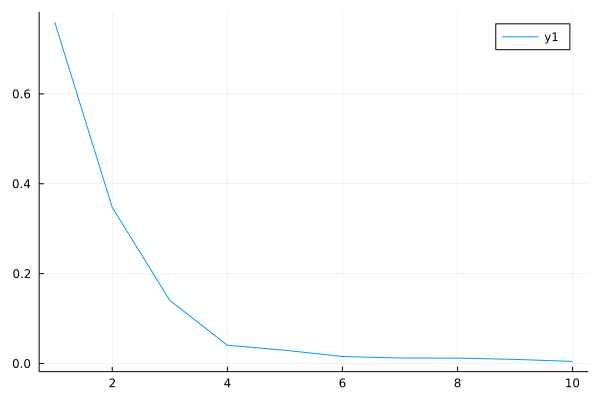

In [180]:
mean_errs = mean(errors, dims=2);
plot(mean_errs)

In [150]:
[0.0 0.0 0.0 0.0 1.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 1.0 0.0 0.0 0.0 0.0] .| [1.0 0.0 0.0 0.0 0.0; 0.0 1.0 0.0 0.0 0.0; 0.0 0.0 1.0 0.0 0.0; 0.0 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 0.0 1.0]

LoadError: MethodError: no method matching |(::Float64, ::Float64)
[0mClosest candidates are:
[0m  |(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m) at ~/.julia/juliaup/julia-1.8.0-beta1+0~x64/share/julia/base/operators.jl:591
[0m  |([91m::DataValues.DataValue{T1}[39m, ::T2) where {T1<:Number, T2<:Number} at ~/.julia/packages/DataValues/N7oeL/src/scalar/core.jl:212
[0m  |([91m::DataValues.DataValue{T1}[39m, ::T2) where {T1, T2} at ~/.julia/packages/DataValues/N7oeL/src/scalar/operations.jl:65
[0m  ...